In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import datetime as dt
import scipy
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
import math


# Set the working directory
ROOT_DIR = os.getcwd()

## Assignment 1: Step Counting
**Name: Ha Le**
**Date: Oct. 1st, 2022**

### Step 1: Load the raw data & Calculate the Magnitude

Using Varun's DataLogger app, I was able to record my step count data and upload it to my local machine. There are three accelometer signals records, one for each of the following scenario:
- Phone in hand: I was holding my phone while walking
- Phone in pocket: I was putting the phone on my jacket's pocket while walking
- Phone in handbag: I was putting the phone inside my handbag while walking.

Since I was using an iphone, the sampling rate is 100Hz.

The chunk of code below will read the three signal and plot them:


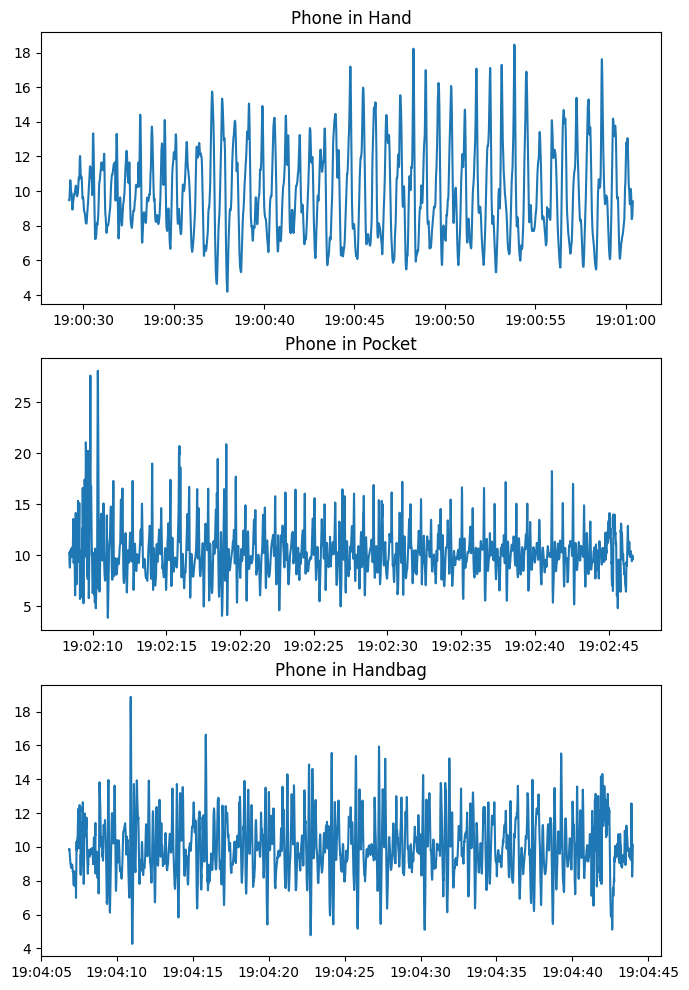

In [2]:
# Load the three accelerometer data files
hand_accel = pd.read_csv(ROOT_DIR + '/../data/phone-in-hand/hand_accel.csv', names=['time', 'x', 'y', 'z'])
pocket_accel = pd.read_csv(ROOT_DIR + '/../data/phone-in-pocket/pocket_accel.csv', names=['time', 'x', 'y', 'z'])
handbag_accel = pd.read_csv(ROOT_DIR + '/../data/phone-in-back/handbag_accel.csv', names=['time', 'x', 'y', 'z'])

#compute the magnitude of the acceleration
hand_accel['mag'] = np.sqrt(hand_accel['x']**2 + hand_accel['y']**2 + hand_accel['z']**2)
pocket_accel['mag'] = np.sqrt(pocket_accel['x']**2 + pocket_accel['y']**2 + pocket_accel['z']**2)
handbag_accel['mag'] = np.sqrt(handbag_accel['x']**2 + handbag_accel['y']**2 + handbag_accel['z']**2)

#convert the time column to datetime
hand_accel['time'] = pd.to_datetime(hand_accel['time'])
pocket_accel['time'] = pd.to_datetime(pocket_accel['time'])
handbag_accel['time'] = pd.to_datetime(handbag_accel['time'])

#plot the magnitude of the acceleration of three activities into 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].plot(hand_accel['time'], hand_accel['mag'])
axs[0].set_title('Phone in Hand')
axs[1].plot(pocket_accel['time'], pocket_accel['mag'])
axs[1].set_title('Phone in Pocket')
axs[2].plot(handbag_accel['time'], handbag_accel['mag'])
axs[2].set_title('Phone in Handbag')
plt.show()



### Step 2: Removing the Noise

After retrieving the raw data and plot the magnitude, as we can see from the plots above, there are a lot of noisy signal from the data. In this notebook, we will be using a frequency filter to remove the noise.

After experimenting with different cutoff frequency (cutoff = [1,2,3,5,10]), I've observed that using the cutoff frequency of 1 yield the best result. 

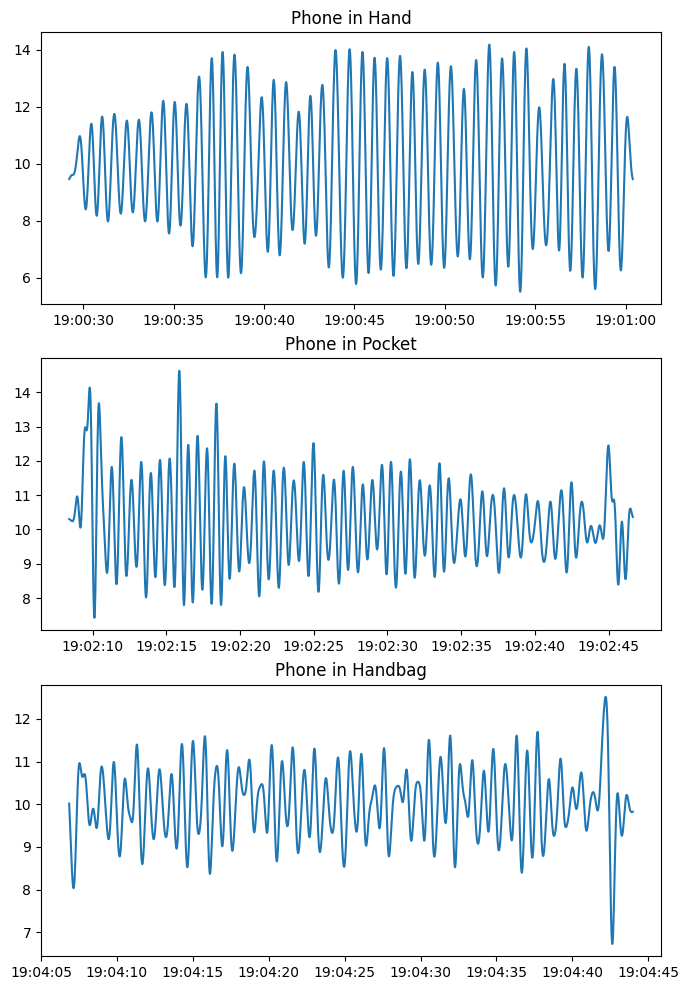

In [3]:
#perform a low pass filter on the magnitude of the acceleration
def low_pass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = scipy.signal.filtfilt(b, a, data)
    return y

#set the sampling frequency
fs = 100

#set the cutoff frequency
cutoff = 2

#apply the low pass filter to the magnitude of the acceleration
hand_accel['mag'] = low_pass_filter(hand_accel['mag'], cutoff, fs)
pocket_accel['mag'] = low_pass_filter(pocket_accel['mag'], cutoff, fs)
handbag_accel['mag'] = low_pass_filter(handbag_accel['mag'], cutoff, fs)

#plot the magnitude of the acceleration of three activities into 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].plot(hand_accel['time'], hand_accel['mag'])
axs[0].set_title('Phone in Hand')
axs[1].plot(pocket_accel['time'], pocket_accel['mag'])
axs[1].set_title('Phone in Pocket')
axs[2].plot(handbag_accel['time'], handbag_accel['mag'])
axs[2].set_title('Phone in Handbag')
plt.show()

As we can see from the plot above, after applying the filter on the magnitude, we get a much clearer signals from the three original dataset.

### Step 3: Step Counting using Adaptive Threshold

In the last dataset, we can see that there are a several double-peak (where the signal have 2 consecutive peak without ever going down, ex. 19:04:27). This might make using peak detection as the step counting method inaccurate. Similarly, since the crossing point for the three signals seem to be different, using zero crossing will not yield the best result.

In the end, after experimenting with different methods, I've decided to use adaptive threshold to count the steps. First, we will need to calculate the threshold for each of the windows in the three signals. According to this [article](https://www.analog.com/media/en/technical-documentation/technical-articles/pedometer.pdf)'s recommendation, a window size of 50 is preferred. However, after experimenting with different window sizes (50, 100, 150, 175, 200), I decided to choose the window size of 175.

After calculating the minimum/maximum bands and the threshold, I generate the plot to verify that my calculation is correct.

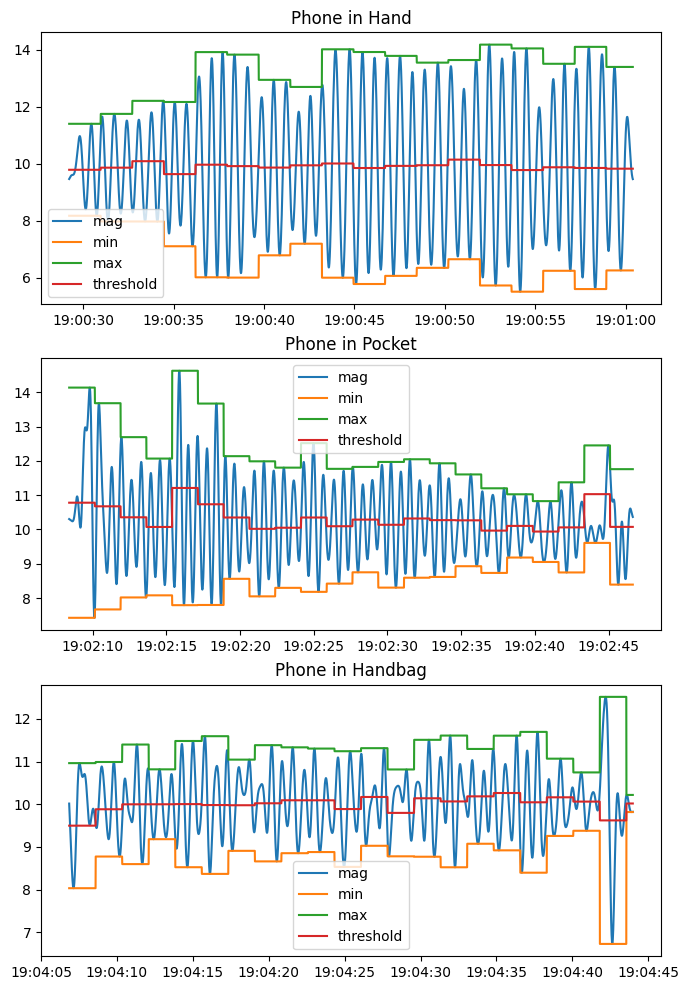

In [4]:
# calculate the dynamic threshold for each activity, window size is 50 and the threshold is calculated as (min + max)/2
window_size = 175

def dynamic_threshold(mag_signal, window_size=50):
      threshold_band = []
      min_band = []
      max_band = []

      for i in range(0, len(mag_signal), window_size):
            modified_window_size = min(window_size, len(mag_signal) - i)
            local_min = min(mag_signal[i:min(i+window_size, len(mag_signal) - 1)])
            local_max = max(mag_signal[i:min(i+window_size, len(mag_signal) - 1)])
            threshold = (local_min + local_max)/2
            min_band += ([local_min] * modified_window_size)
            max_band += ([local_max] * modified_window_size)
            threshold_band += ([threshold] * modified_window_size)

      return min_band, max_band, threshold_band

#calculate the dynamic threshold for phone_in_hand activity
hand_min, hand_max, hand_threshold = dynamic_threshold(hand_accel['mag'], window_size)
hand_accel['min'] = hand_min
hand_accel['max'] = hand_max
hand_accel['threshold'] = hand_threshold

#calculate the dynamic threshold for phone_in_pocket activity
pocket_min, pocket_max, pocket_threshold = dynamic_threshold(pocket_accel['mag'], window_size)
pocket_accel['min'] = pocket_min
pocket_accel['max'] = pocket_max
pocket_accel['threshold'] = pocket_threshold

#calculate the dynamic threshold for phone_in_handbag activity
handbag_min, handbag_max, handbag_threshold = dynamic_threshold(handbag_accel['mag'],    window_size)
handbag_accel['min'] = handbag_min
handbag_accel['max'] = handbag_max
handbag_accel['threshold'] = handbag_threshold

# plot the min, max and threshold against the magnitude of the acceleration
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].plot(hand_accel['time'], hand_accel['mag'], label='mag')
axs[0].plot(hand_accel['time'], hand_accel['min'], label='min')
axs[0].plot(hand_accel['time'], hand_accel['max'], label='max')
axs[0].plot(hand_accel['time'], hand_accel['threshold'], label='threshold')
axs[0].set_title('Phone in Hand')
axs[0].legend()
axs[1].plot(pocket_accel['time'], pocket_accel['mag'], label='mag')
axs[1].plot(pocket_accel['time'], pocket_accel['min'], label='min')
axs[1].plot(pocket_accel['time'], pocket_accel['max'], label='max')
axs[1].plot(pocket_accel['time'], pocket_accel['threshold'], label='threshold')
axs[1].set_title('Phone in Pocket')
axs[1].legend()
axs[2].plot(handbag_accel['time'], handbag_accel['mag'], label='mag')
axs[2].plot(handbag_accel['time'], handbag_accel['min'], label='min')
axs[2].plot(handbag_accel['time'], handbag_accel['max'], label='max')
axs[2].plot(handbag_accel['time'], handbag_accel['threshold'], label='threshold')
axs[2].set_title('Phone in Handbag')
axs[2].legend()
plt.show()


After the threshold is determine, now we can start using it to count the steps:

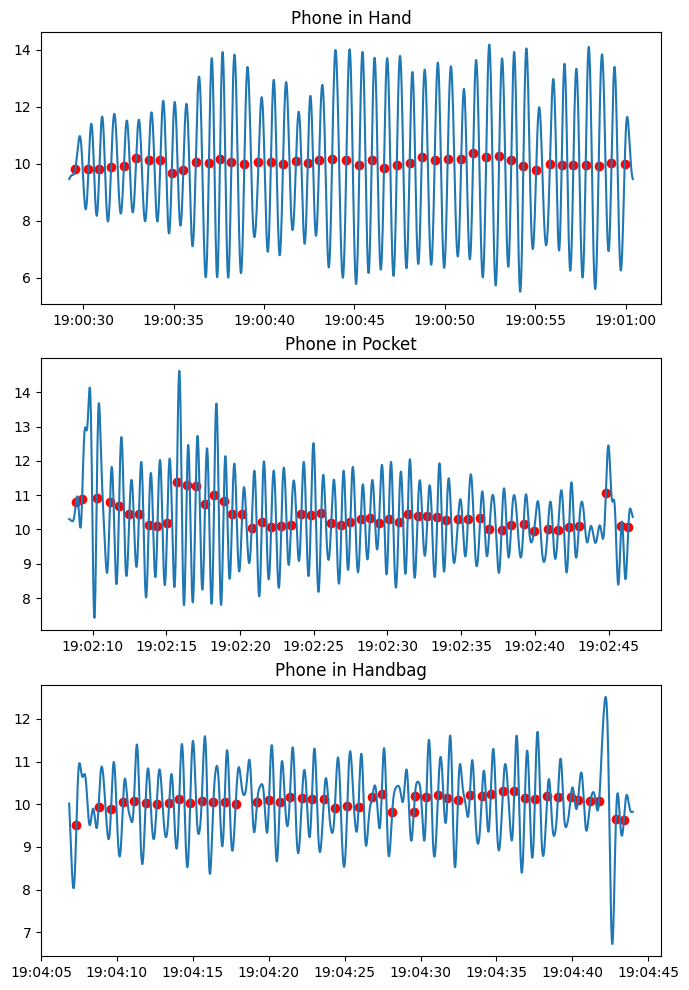

In [5]:
# a function to perform zero crossing according to the dynamic threshold
def threshold_crossing(mag_signal, threshold_signal):
    crossing = [0]
    for i in range(1, len(mag_signal)):
        if (mag_signal[i] > threshold_signal[i]) and (mag_signal[i-1] < threshold_signal[i-1]):
            crossing.append(1)
        elif (mag_signal[i] < threshold_signal[i]) and (mag_signal[i-1] > threshold_signal[i-1]):
            crossing.append(-1)
        else:
            crossing.append(0)
    return crossing

#perform threshold crossing on the magnitude of the acceleration
hand_accel['crossing'] = threshold_crossing(hand_accel['mag'], hand_accel['threshold'])
pocket_accel['crossing'] = threshold_crossing(pocket_accel['mag'], pocket_accel['threshold'])
handbag_accel['crossing'] = threshold_crossing(handbag_accel['mag'], handbag_accel['threshold'])

#generate the point-wise data of the crossing signal so we can plot it
hand_x = [hand_accel['mag'][i] for i in range(len(hand_accel['crossing'])) if hand_accel['crossing'][i] == 1]
hand_y = [hand_accel['time'][i] for i in range(len(hand_accel['crossing'])) if hand_accel['crossing'][i] == 1]
pocket_x = [pocket_accel['mag'][i] for i in range(len(pocket_accel['crossing'])) if pocket_accel['crossing'][i] == 1]
pocket_y = [pocket_accel['time'][i] for i in range(len(pocket_accel['crossing'])) if pocket_accel['crossing'][i] == 1]
handbag_x = [handbag_accel['mag'][i] for i in range(len(handbag_accel['crossing'])) if handbag_accel['crossing'][i] == 1]
handbag_y = [handbag_accel['time'][i] for i in range(len(handbag_accel['crossing'])) if handbag_accel['crossing'][i] == 1]

#plot the threshold crossing
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].plot(hand_accel['time'], hand_accel['mag'])
axs[0].scatter(hand_y, hand_x, color='red')
axs[0].set_title('Phone in Hand')
axs[1].plot(pocket_accel['time'], pocket_accel['mag'])
axs[1].scatter(pocket_y, pocket_x, color='red')
axs[1].set_title('Phone in Pocket')
axs[2].plot(handbag_accel['time'], handbag_accel['mag'])
axs[2].scatter(handbag_y, handbag_x, color='red')
axs[2].set_title('Phone in Handbag')
plt.show()



Let's try comparing our results with the results from the in-app step counting algorithm. First, we need to read the data from the step files in the three folders:

In [6]:
#read the step data from the three folders

hand_step = pd.read_csv(ROOT_DIR + '/../data/phone-in-hand/hand_step.csv', names=['time', 'step', ''])
pocket_step = pd.read_csv(ROOT_DIR + '/../data/phone-in-pocket/pocket_step.csv', names=['time', 'step', ''])
handbag_step = pd.read_csv(ROOT_DIR + '/../data/phone-in-back/handbag_step.csv', names=['time', 'step', ''])

# let's try to mutate the data into something more readable
comparison_df = pd.DataFrame(columns=['dataset', 'DataLogger\'s algorithm', 'Ha\'s algorithm'])
comparison_df['dataset'] = ['Phone in Hand', 'Phone in Pocket', 'Phone in Handbag']
comparison_df['DataLogger\'s algorithm'] = [list(hand_step['step'])[-1], list(pocket_step['step'])[-1], list(handbag_step['step'])[-1]]
comparison_df['Ha\'s algorithm'] = [len(hand_y), len(pocket_y), len(handbag_y)]

#print the comparison
comparison_df


,dataset,DataLogger's algorithm,Ha's algorithm
0,Phone in Hand,45,45
1,Phone in Pocket,50,54
2,Phone in Handbag,37,48
